## Introduction

KerasNLP provides building blocks for NLP (model layers, tokenizers, metrics, etc.) and
makes it convenient to construct NLP pipelines.

In this example, we'll use KerasNLP layers to build an encoder-decoder Transformer
model, and train it on the English-to-Spanish machine translation task.

You'll learn how to:

- Tokenize text using `keras_nlp.tokenizers.WordPieceTokenizer`.
- Implement a sequence-to-sequence Transformer model using KerasNLP's
`keras_nlp.layers.TransformerEncoder`, `keras_nlp.layers.TransformerDecoder` and
`keras_nlp.layers.TokenAndPositionEmbedding` layers, and train it.
- Use `keras_nlp.samplers` to generate translations of unseen input sentences
 using the top-p decoding strategy!

Don't worry if you aren't familiar with KerasNLP. This tutorial will start with
the basics. Let's dive right in!

## Setup

Before we start implementing the pipeline, let's import all the libraries we need.

In [1]:
!pip install -q --upgrade rouge-score
!pip install -q --upgrade keras-nlp
!pip install -q --upgrade keras  # Upgrade to Keras 3.
!pip install -q tensorflowjs

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 570.5/570.5 kB 5.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 950.8/950.8 kB 12.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.2/5.2 MB 25.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 589.8/589.8 MB 2.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.3/5.3 MB 74.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 67.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 73.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 55.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 311.2/311.2 kB 34.0 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tf-keras 2.15.1 requires tensorflow<2.16,>=2.15, but you ha

In [1]:
import keras_nlp
import pathlib
import random
import json

import keras
from keras import ops

import tensorflow.data as tf_data
from tensorflow_text.tools.wordpiece_vocab import (
    bert_vocab_from_dataset as bert_vocab,
)

Let's also define our parameters/hyperparameters.

In [23]:
BATCH_SIZE = 64
EPOCHS = 10  # This should be at least 10 for convergence
MAX_SEQUENCE_LENGTH = 100
INDO_VOCAB_SIZE = 30000
JAVA_VOCAB_SIZE = 30000

EMBED_DIM = 256
INTERMEDIATE_DIM = 2048
NUM_HEADS = 8

## Downloading the data

We'll be working with an English-to-Spanish translation dataset
provided by [Anki](https://www.manythings.org/anki/). Let's download it:

### Upload the Dataset

In [5]:
import pandas as pd

In [ ]:
df = pd.read_csv("/content/ind-jav.csv", encoding='latin1')
df

,English,Indonesian,Javanese
0,Hi.,Hai.,Hai.
1,Run!,Lari!,Mlayu!
2,Run.,Lari!,Mlayu!
3,Who?,Siapa?,sopo?
4,Wow!,Wow!,wah!
...,...,...,...
13565,"When she was finished ironing, Mary switched o...","Ketika dia sudah selesai menyetrika, Mary mema...","Sawise rampung nyetrika, Mary mateni wesi banj..."
13566,"When he got up to make his speech, Tom's mind ...","Ketika Tom berdiri untuk pidato, pikirannya ti...","Nalika Tom ngadeg kanggo wicara, pikirane duma..."
13567,"January, February, March, April, May, June, Ju...","Januari, Februari, Maret, April, Mei, Juni, Ju...","Januari, Februari, Maret, April, Mei, Juni, Ju..."
13568,"Irene Pepperberg, a researcher at Northwestern...","Irene Pepperberg, seorang peneliti di Universi...","Irene Pepperberg, peneliti ing Northwestern Un..."


In [ ]:
df.drop(columns=['English'], inplace=True)
df

,Indonesian,Javanese
0,Hai.,Hai.
1,Lari!,Mlayu!
2,Lari!,Mlayu!
3,Siapa?,sopo?
4,Wow!,wah!
...,...,...
13565,"Ketika dia sudah selesai menyetrika, Mary mema...","Sawise rampung nyetrika, Mary mateni wesi banj..."
13566,"Ketika Tom berdiri untuk pidato, pikirannya ti...","Nalika Tom ngadeg kanggo wicara, pikirane duma..."
13567,"Januari, Februari, Maret, April, Mei, Juni, Ju...","Januari, Februari, Maret, April, Mei, Juni, Ju..."
13568,"Irene Pepperberg, seorang peneliti di Universi...","Irene Pepperberg, peneliti ing Northwestern Un..."


In [6]:
output_file_path = '/content/ind-java.txt'
df.to_csv(output_file_path, sep="\t", index=False, header=False)

NameError: name 'df' is not defined

## Parsing the data

Each line contains an English sentence and its corresponding Spanish sentence.
The English sentence is the *source sequence* and Spanish one is the *target sequence*.
Before adding the text to a list, we convert it to lowercase.

In [7]:
import pathlib

text_file = pathlib.Path("/content/ind-java.txt")

In [8]:
with open(text_file) as f:
    lines = f.read().split("\n")[:-1]
text_pairs = []
for line in lines:
    indo, java = line.split("\t")
    indo = indo.lower()
    java = java.lower()
    text_pairs.append((indo, java))

Here's what our sentence pairs look like:

In [9]:
for _ in range(5):
    print(random.choice(text_pairs))

('akibat alam yang tak bersahabat, sejumlah kuil, situs bersejarah, candi dan artefak lain lebih cepat rusak dibandingkan beberapa waktu silam.', 'amarga alam musuhan, sawetara kuil, situs sajarah, candhi lan artefak liyane rusak luwih cepet tinimbang sadurunge.')
('tom memakan lebih banyak es krim daripada aku.', 'tom mangan es krim luwih akeh tinimbang aku.')
('keberhasilan situs-situs komunitas indonesia sebenarnya tak bisa dinilai dengan uang.', 'kasuksesan situs komunitas indonesia ora bisa dinilai kanthi dhuwit.')
('buaya-buaya itu berukuran panjang antara 40-50 centimeter.', 'dawane baya antara 40-50 sentimeter.')
('kamu tidak bisa menjadi seorang dokter.', 'sampeyan ora bisa dadi dhokter.')


Now, let's split the sentence pairs into a training set, a validation set,
and a test set.

In [10]:
import random

# Assuming text_pairs is defined elsewhere
random.shuffle(text_pairs)
num_val_samples = int(0.15 * len(text_pairs))
num_train_samples = len(text_pairs) - num_val_samples
train_pairs = text_pairs[:num_train_samples]
val_pairs = text_pairs[num_train_samples:]

print(f"{len(text_pairs)} total pairs")
print(f"{len(train_pairs)} training pairs")
print(f"{len(val_pairs)} validation pairs")

38692 total pairs
32889 training pairs
5803 validation pairs


## Tokenizing the data

We'll define two tokenizers - one for the source language (Indonesia), and the other
for the target language (Javanese). We'll be using
`keras_nlp.tokenizers.WordPieceTokenizer` to tokenize the text.
`keras_nlp.tokenizers.WordPieceTokenizer` takes a WordPiece vocabulary
and has functions for tokenizing the text, and detokenizing sequences of tokens.

Before we define the two tokenizers, we first need to train them on the dataset
we have. The WordPiece tokenization algorithm is a subword tokenization algorithm;
training it on a corpus gives us a vocabulary of subwords. A subword tokenizer
is a compromise between word tokenizers (word tokenizers need very large
vocabularies for good coverage of input words), and character tokenizers
(characters don't really encode meaning like words do). Luckily, KerasNLP
makes it very simple to train WordPiece on a corpus with the
`keras_nlp.tokenizers.compute_word_piece_vocabulary` utility.

In [11]:

def train_word_piece(text_samples, vocab_size, reserved_tokens):
    word_piece_ds = tf_data.Dataset.from_tensor_slices(text_samples)
    vocab = keras_nlp.tokenizers.compute_word_piece_vocabulary(
        word_piece_ds.batch(1000).prefetch(2),
        vocabulary_size=vocab_size,
        reserved_tokens=reserved_tokens,
    )
    return vocab


Every vocabulary has a few special, reserved tokens. We have four such tokens:

- `"[PAD]"` - Padding token. Padding tokens are appended to the input sequence
length when the input sequence length is shorter than the maximum sequence length.
- `"[UNK]"` - Unknown token.
- `"[START]"` - Token that marks the start of the input sequence.
- `"[END]"` - Token that marks the end of the input sequence.

In [12]:
reserved_tokens = ["[PAD]", "[UNK]", "[START]", "[END]"]

indo_samples = [text_pair[0] for text_pair in train_pairs]
indo_vocab = train_word_piece(indo_samples, INDO_VOCAB_SIZE, reserved_tokens)

java_samples = [text_pair[1] for text_pair in train_pairs]
java_vocab = train_word_piece(java_samples, JAVA_VOCAB_SIZE, reserved_tokens)

Let's see some tokens!

In [13]:
print("Indo Tokens: ", indo_vocab[100:110])
print("Java Tokens: ", java_vocab[100:110])

Indo Tokens:  ['bahwa', 'kami', 'adalah', 'oleh', 'ada', 'bisa', '##kan', 'mengatakan', 'satu', 'dapat']
Java Tokens:  ['kita', 'nalika', '##e', 'luwih', 'menyang', 'rp', 'as', 'dening', 'sawise', 'negara']


Now, let's define the tokenizers. We will configure the tokenizers with the
the vocabularies trained above.

In [14]:
indo_tokenizer = keras_nlp.tokenizers.WordPieceTokenizer(
    vocabulary=indo_vocab, lowercase=False
)
java_tokenizer = keras_nlp.tokenizers.WordPieceTokenizer(
    vocabulary=java_vocab, lowercase=False
)

Let's try and tokenize a sample from our dataset! To verify whether the text has
been tokenized correctly, we can also detokenize the list of tokens back to the
original text.

In [15]:
indo_input_ex = text_pairs[0][0]
indo_tokens_ex = indo_tokenizer.tokenize(indo_input_ex)
print("Indonesia sentence: ", indo_input_ex)
print("Tokens: ", indo_tokens_ex)
print(
    "Recovered text after detokenizing: ",
    indo_tokenizer.detokenize(indo_tokens_ex),
)

print()

java_input_ex = text_pairs[0][1]
java_tokens_ex = java_tokenizer.tokenize(java_input_ex)
print("Java sentence: ", java_input_ex)
print("Tokens: ", java_tokens_ex)
print(
    "Recovered text after detokenizing: ",
    java_tokenizer.detokenize(java_tokens_ex),
)

Indonesia sentence:  werder bremen ditahan bermain imbang 1-1 di kandang tim yang lagi terancam degradasi, arminia bielefeld, minggu.
Tokens:  tf.Tensor(
[2937 2467 1174  266  964   19   15   19   70  770  152   69  166 2633
 2665   14   37 3261 2449  129  234  741 3963  741  276   14  305   16], shape=(28,), dtype=int32)
Recovered text after detokenizing:  tf.Tensor(b'werder bremen ditahan bermain imbang 1 - 1 di kandang tim yang lagi terancam degradasi , arminia bielefeld , minggu .', shape=(), dtype=string)

Java sentence:  werder bremen ditahan imbang 1-1 ing omah nglawan tim sing diancam degradasi arminia bielefeld dina minggu.
Tokens:  tf.Tensor(
[2758 2303 1025  524   19   15   19   71  314  172  158   72 5648 2158
   36 5540 2192  136  209  662  102 4463  110  149   16], shape=(25,), dtype=int32)
Recovered text after detokenizing:  tf.Tensor(b'werder bremen ditahan imbang 1 - 1 ing omah nglawan tim sing diancam degradasi arminia bielefeld dina minggu .', shape=(), dtype=string)

## Format datasets

Next, we'll format our datasets.

At each training step, the model will seek to predict target words N+1 (and beyond)
using the source sentence and the target words 0 to N.

As such, the training dataset will yield a tuple `(inputs, targets)`, where:

- `inputs` is a dictionary with the keys `encoder_inputs` and `decoder_inputs`.
`encoder_inputs` is the tokenized source sentence and `decoder_inputs` is the target
sentence "so far",
that is to say, the words 0 to N used to predict word N+1 (and beyond) in the target
sentence.
- `target` is the target sentence offset by one step:
it provides the next words in the target sentence -- what the model will try to predict.

We will add special tokens, `"[START]"` and `"[END]"`, to the input Spanish
sentence after tokenizing the text. We will also pad the input to a fixed length.
This can be easily done using `keras_nlp.layers.StartEndPacker`.

In [16]:

def preprocess_batch(indo, java):
    batch_size = ops.shape(indo)[0]

    indo = indo_tokenizer(indo)
    java = java_tokenizer(java)

    # Pad `indo` to `MAX_SEQUENCE_LENGTH`.
    indo_start_end_packer = keras_nlp.layers.StartEndPacker(
        sequence_length=MAX_SEQUENCE_LENGTH,
        pad_value=indo_tokenizer.token_to_id("[PAD]"),
    )
    indo = indo_start_end_packer(indo)

    # Add special tokens (`"[START]"` and `"[END]"`) to `java` and pad it as well.
    java_start_end_packer = keras_nlp.layers.StartEndPacker(
        sequence_length=MAX_SEQUENCE_LENGTH + 1,
        start_value=java_tokenizer.token_to_id("[START]"),
        end_value=java_tokenizer.token_to_id("[END]"),
        pad_value=java_tokenizer.token_to_id("[PAD]"),
    )
    java = java_start_end_packer(java)

    return (
        {
            "encoder_inputs": indo,
            "decoder_inputs": java[:, :-1],
        },
        java[:, 1:],
    )


def make_dataset(pairs):
    eng_texts, java_texts = zip(*pairs)
    eng_texts = list(eng_texts)
    java_texts = list(java_texts)
    dataset = tf_data.Dataset.from_tensor_slices((eng_texts, java_texts))
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.map(preprocess_batch, num_parallel_calls=tf_data.AUTOTUNE)
    return dataset.cache().shuffle(128).prefetch(16)


train_ds = make_dataset(train_pairs)
val_ds = make_dataset(val_pairs)

Let's take a quick look at the sequence shapes
(we have batches of 64 pairs, and all sequences are 40 steps long):

In [17]:
for inputs, targets in train_ds.take(1):
    print(f'inputs["encoder_inputs"].shape: {inputs["encoder_inputs"].shape}')
    print(f'inputs["decoder_inputs"].shape: {inputs["decoder_inputs"].shape}')
    print(f"targets.shape: {targets.shape}")


inputs["encoder_inputs"].shape: (64, 100)
inputs["decoder_inputs"].shape: (64, 100)
targets.shape: (64, 100)


## Building the model

This embedding layer can be initialised randomly. We also need a positional
embedding layer which encodes the word order in the sequence. The convention is
to add these two embeddings. KerasNLP has a `keras_nlp.layers.TokenAndPositionEmbedding `
layer which does all of the above steps for us.

Our sequence-to-sequence Transformer consists of a `keras_nlp.layers.TransformerEncoder`
layer and a `keras_nlp.layers.TransformerDecoder` layer chained together.

The source sequence will be passed to `keras_nlp.layers.TransformerEncoder`, which
will produce a new representation of it. This new representation will then be passed
to the `keras_nlp.layers.TransformerDecoder`, together with the target sequence
so far (target words 0 to N). The `keras_nlp.layers.TransformerDecoder` will
then seek to predict the next words in the target sequence (N+1 and beyond).

A key detail that makes this possible is causal masking.
The `keras_nlp.layers.TransformerDecoder` sees the entire sequence at once, and
thus we must make sure that it only uses information from target tokens 0 to N
when predicting token N+1 (otherwise, it could use information from the future,
which would result in a model that cannot be used at inference time). Causal masking
is enabled by default in `keras_nlp.layers.TransformerDecoder`.

We also need to mask the padding tokens (`"[PAD]"`). For this, we can set the
`mask_zero` argument of the `keras_nlp.layers.TokenAndPositionEmbedding` layer
to True. This will then be propagated to all subsequent layers.

In [24]:
# Encoder
encoder_inputs = keras.Input(batch_shape=(None, MAX_SEQUENCE_LENGTH,), name="encoder_inputs")

x = keras_nlp.layers.TokenAndPositionEmbedding(
    vocabulary_size=INDO_VOCAB_SIZE,
    sequence_length=MAX_SEQUENCE_LENGTH,
    embedding_dim=EMBED_DIM,
)(encoder_inputs)

encoder_outputs = keras_nlp.layers.TransformerEncoder(
    intermediate_dim=INTERMEDIATE_DIM, num_heads=NUM_HEADS
)(inputs=x)
encoder = keras.Model(encoder_inputs, encoder_outputs)


# Decoder
decoder_inputs = keras.Input(batch_shape=(None, MAX_SEQUENCE_LENGTH,), name="decoder_inputs")
encoded_seq_inputs = keras.Input(batch_shape=(None, None, EMBED_DIM), name="decoder_state_inputs")

x = keras_nlp.layers.TokenAndPositionEmbedding(
    vocabulary_size=JAVA_VOCAB_SIZE,
    sequence_length=MAX_SEQUENCE_LENGTH,
    embedding_dim=EMBED_DIM,
)(decoder_inputs)

x = keras_nlp.layers.TransformerDecoder(
    intermediate_dim=INTERMEDIATE_DIM, num_heads=NUM_HEADS
)(decoder_sequence=x, encoder_sequence=encoded_seq_inputs)
x = keras.layers.Dropout(0.5)(x)
decoder_outputs = keras.layers.Dense(JAVA_VOCAB_SIZE, activation="softmax")(x)
decoder = keras.Model(
    [
        decoder_inputs,
        encoded_seq_inputs,
    ],
    decoder_outputs,
)
decoder_outputs = decoder([decoder_inputs, encoder_outputs])

transformer = keras.Model(
    [encoder_inputs, decoder_inputs],
    decoder_outputs,
    name="transformer",
)

## Training our model

We'll use accuracy as a quick way to monitor training progress on the validation data.
Note that machine translation typically uses BLEU scores as well as other metrics,
rather than accuracy. However, in order to use metrics like ROUGE, BLEU, etc. we
will have decode the probabilities and generate the text. Text generation is
computationally expensive, and performing this during training is not recommended.

Here we only train for 1 epoch, but to get the model to actually converge
you should train for at least 10 epochs.

In [25]:
transformer.summary()
transformer.compile(
    "rmsprop", loss="sparse_categorical_crossentropy", metrics=["accuracy"])

Model: "transformer"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ encoder_inputs            │ (None, 100)            │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ token_and_position_embed… │ (None, 100, 256)       │      7,705,600 │ encoder_inputs[0][0]   │
│ (TokenAndPositionEmbeddi… │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ decoder_inputs            │ (None, 100)            │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ transformer_encoder_2     │ (None, 100, 256)       │      1,315,072 │ token_and_position_em… │
│ (TransformerEncoder)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ functional_11             │ (None, 100, 30000)     │     16,994,352 │ decoder_inputs[0][0],  │
│ (Functional)              │                        │                │ transformer_encoder_2… │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 26,015,024 (99.24 MB)

 Trainable params: 26,015,024 (99.24 MB)

 Non-trainable params: 0 (0.00 B)

In [26]:
history = transformer.fit(train_ds, epochs=EPOCHS, validation_data=val_ds)

Epoch 1/10
514/514 ━━━━━━━━━━━━━━━━━━━━ 121s 209ms/step - accuracy: 0.7941 - loss: 2.3079 - val_accuracy: 0.8211 - val_loss: 1.2285
Epoch 2/10
514/514 ━━━━━━━━━━━━━━━━━━━━ 95s 185ms/step - accuracy: 0.8214 - loss: 1.2175 - val_accuracy: 0.8261 - val_loss: 1.1253
Epoch 3/10
514/514 ━━━━━━━━━━━━━━━━━━━━ 94s 183ms/step - accuracy: 0.8272 - loss: 1.1203 - val_accuracy: 0.8365 - val_loss: 1.0316
Epoch 4/10
514/514 ━━━━━━━━━━━━━━━━━━━━ 94s 182ms/step - accuracy: 0.8406 - loss: 1.0093 - val_accuracy: 0.8553 - val_loss: 0.8922
Epoch 5/10
514/514 ━━━━━━━━━━━━━━━━━━━━ 94s 182ms/step - accuracy: 0.8586 - loss: 0.8719 - val_accuracy: 0.8710 - val_loss: 0.7852
Epoch 6/10
514/514 ━━━━━━━━━━━━━━━━━━━━ 94s 183ms/step - accuracy: 0.8734 - loss: 0.7612 - val_accuracy: 0.8812 - val_loss: 0.7102
Epoch 7/10
514/514 ━━━━━━━━━━━━━━━━━━━━ 94s 182ms/step - accuracy: 0.8835 - loss: 0.6808 - val_accuracy: 0.8870 - val_loss: 0.6633
Epoch 8/10
514/514 ━━━━━━━━━━━━━━━━━━━━ 94s 182ms/step - accuracy: 0.8919 - loss: 

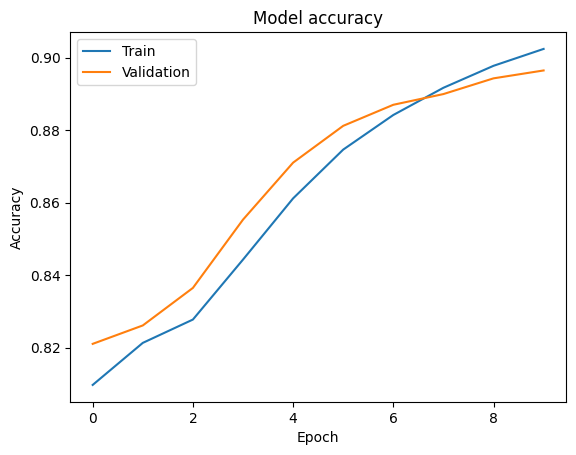

In [27]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

## Decoding test sentences (qualitative analysis)

Finally, let's demonstrate how to translate brand new English sentences.
We simply feed into the model the tokenized English sentence
as well as the target token `"[START]"`. The model outputs probabilities of the
next token. We then we repeatedly generated the next token conditioned on the
tokens generated so far, until we hit the token `"[END]"`.

For decoding, we will use the `keras_nlp.samplers` module from
KerasNLP. Greedy Decoding is a text decoding method which outputs the most
likely next token at each time step, i.e., the token with the highest probability.

In [32]:
def decode_sequences(input_sentences):
    batch_size = 1

    # Tokenize the encoder input.
    encoder_input_tokens = ops.convert_to_tensor(indo_tokenizer(input_sentences))
    if len(encoder_input_tokens[0]) < MAX_SEQUENCE_LENGTH:
        pads = ops.full((1, MAX_SEQUENCE_LENGTH - len(encoder_input_tokens[0])), 0)
        encoder_input_tokens = ops.concatenate(
            [encoder_input_tokens.to_tensor(), pads], 1
        )

    # Define a function that outputs the next token's probability given the
    # input sequence.
    def next(prompt, cache, index):
        logits = transformer([encoder_input_tokens, prompt])[:, index - 1, :]
        # Ignore hidden states for now; only needed for contrastive search.
        hidden_states = None
        return logits, hidden_states, cache

    # Build a prompt of length 40 with a start token and padding tokens.
    length = 100
    start = ops.full((batch_size, 1), java_tokenizer.token_to_id("[START]"))
    pad = ops.full((batch_size, length - 1), java_tokenizer.token_to_id("[PAD]"))
    prompt = ops.concatenate((start, pad), axis=-1)

    generated_tokens = keras_nlp.samplers.GreedySampler()(
        next,
        prompt,
        stop_token_ids=[java_tokenizer.token_to_id("[END]")],
        index=1,  # Start sampling after start token.
    )
    generated_sentences = java_tokenizer.detokenize(generated_tokens)
    return generated_sentences

input_sentence = "dimanakah tempat ini berada?"
translated = decode_sequences([input_sentence])
translated = translated.numpy()[0].decode("utf-8")
translated = (
    translated.replace("[PAD]", "")
    .replace("[START]", "")
    .replace("[END]", "")
    .strip()
)
print(input_sentence)
print(translated)
print()

dimanakah tempat ini berada?
ngendi endi papan iki ?



In [ ]:
input_sentence = "halo, bagaimana kabarmu?"
translated = decode_sequences([input_sentence])
translated = translated.numpy()[0].decode("utf-8")
translated = (
    translated.replace("[PAD]", "")
    .replace("[START]", "")
    .replace("[END]", "")
    .strip()
)
print(input_sentence)
print(translated)
print()

halo, bagaimana kabarmu?
halo , piye kabare ?



## Evaluating our model (quantitative analysis)

There are many metrics which are used for text generation tasks. Here, to
evaluate translations generated by our model, let's compute the ROUGE-1 and
ROUGE-2 scores. Essentially, ROUGE-N is a score based on the number of common
n-grams between the reference text and the generated text. ROUGE-1 and ROUGE-2
use the number of common unigrams and bigrams, respectively.

We will calculate the score over 30 test samples (since decoding is an
expensive process).

In [ ]:
rouge_1 = keras_nlp.metrics.RougeN(order=1)
rouge_2 = keras_nlp.metrics.RougeN(order=2)

for test_pair in val_pairs[:30]:
    input_sentence = test_pair[0]
    reference_sentence = test_pair[1]

    translated_sentence = decode_sequences([input_sentence])
    translated_sentence = translated_sentence.numpy()[0].decode("utf-8")
    translated_sentence = (
        translated_sentence.replace("[PAD]", "")
        .replace("[START]", "")
        .replace("[END]", "")
        .strip()
    )

    rouge_1(reference_sentence, translated_sentence)
    rouge_2(reference_sentence, translated_sentence)

print("ROUGE-1 Score: ", rouge_1.result())
print("ROUGE-2 Score: ", rouge_2.result())

ROUGE-1 Score:  {'precision': <tf.Tensor: shape=(), dtype=float32, numpy=0.6349494>, 'recall': <tf.Tensor: shape=(), dtype=float32, numpy=0.6267856>, 'f1_score': <tf.Tensor: shape=(), dtype=float32, numpy=0.62550294>}
ROUGE-2 Score:  {'precision': <tf.Tensor: shape=(), dtype=float32, numpy=0.4065873>, 'recall': <tf.Tensor: shape=(), dtype=float32, numpy=0.4090476>, 'f1_score': <tf.Tensor: shape=(), dtype=float32, numpy=0.4032193>}


After 10 epochs, the scores are as follows:

|               | **ROUGE-1** | **ROUGE-2** |
|:-------------:|:-----------:|:-----------:|
| **Precision** |    0.568    |    0.374    |
|   **Recall**  |    0.615    |    0.394    |
|  **F1 Score** |    0.579    |    0.381    |

In [33]:
transformer.save('indo-java.h5')
transformer.save('indo-java.keras')

In [42]:
import tensorflow as tf

model = tf.keras.models.load_model('/content/indo-java.keras')
tf.saved_model.save(model, '/content/my_saved_model')

In [34]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [44]:
!tensorflowjs_converter --input_format=tf_saved_model "/content/my_saved_model" "/content/my_tfjs_model"


2024-06-13 16:24:20.936504: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
2024-06-13 16:24:22.909773: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:47] Overriding orig_value setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
2024-06-13 16:24:23.257641: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 30720000 exceeds 10% of free system memory.
2024-06-13 16:24:23.294998: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 30720000 exceeds 10% of free system memory.
2024-06-13 16:24:23.334838: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 30720000 exceeds 10% of free system memory.
2024-06-13 16:24:23.369408: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 30720000 exceeds 10% of free system memory.
2024-06-13 16:24:23.413486: W external/local_tsl/tsl/framework/cpu_alloc

In [37]:
!tensorflowjs_converter --input_format=keras "/content/indo-java.h5" "/content/indo-java_tfjs-keras"


2024-06-13 16:10:24.313506: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
failed to lookup keras version from the file,
    this is likely a weight only file


In [46]:
!cp -r "/content/my_tfjs_model" "/content/gdrive/MyDrive/Bangkit-Capstone-In-to-Java/tfjs-keras-model"

In [47]:
!cp -r "/content/my_saved_model" "/content/gdrive/MyDrive/Bangkit-Capstone-In-to-Java/tfjs-keras-model"

In [ ]:
from google.colab import files

files.download('indo-java.txt')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [48]:
import json

with open('indo_vocab.json', 'w') as f:
    json.dump(indo_vocab, f)

with open('java_vocab.json', 'w') as f:
    json.dump(java_vocab, f)